In [269]:
import pandas as pd
import numpy as np

import xgboost as xgb

import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn import preprocessing

from tqdm import tqdm

from sklearn.pipeline import make_pipeline

О наборе данных
Пол голоса
Распознавание пола по голосу и анализу речи

Эта база данных была создана для идентификации голоса как мужского или женского на основе акустических свойств голоса и речи. Набор данных состоит из 3168 записанных образцов голоса, собранных от мужчин и женщин, говорящих. Образцы голоса предварительно обрабатываются с помощью акустического анализа в R с использованием пакетов seewave и tuneR с анализируемым диапазоном частот 0 Гц-280 Гц (диапазон человеческого голоса).

Набор данных
Следующие акустические свойства каждого голоса измеряются и включаются в CSV:

* meanfreq: средняя частота (в кГц)
* sd: стандартное отклонение частоты
* медиана: средняя частота (в кГц)
* Q25: первый квантиль (в кГц)
* Q75: третий квантиль (в кГц)
* IQR: межквантовый диапазон (в кГц)
* перекос: перекос (см. примечание в описании specprop)
* kurt: эксцесс (см. примечание в описании specprop)
* sp.ent: спектральная энтропия
* sfm:
режим спектральной плоскостности
пик центроида
среднее
значение минимальное значение максимальное
значение
среднее
значение
* mindom: минимум доминирующей частоты, измеренной в акустическом сигнале
* maxdom: максимум доминирующей частоты, измеренной в акустическом сигнале
* dfrange: диапазон доминирующей частоты, измеренный по акустическому сигналу
* modindx: индекс модуляции. Рассчитывается как накопленная абсолютная разница между соседними измерениями основных частот, деленная на метку частотного диапазона
: мужской или женский
Точность
Исходная линия (всегда прогнозируемый мужчина)
50% / 50%

Логистическая регрессия
97% / 98%

корзина
96% / 97%

Случайный лес
100% / 98%

SVM
100% / 99%

XGBoost
100% / 99%

Исследовательские вопросы
Оригинальный анализ набора данных можно найти в следующей статье:

Определение пола голоса с помощью машинного обучения

Лучшая модель достигает 99% точности на тестовом наборе. Согласно модели CART, похоже, что для точной классификации голоса может быть достаточно взглянуть на среднюю основную частоту. Однако некоторые мужские голоса используют более высокую частоту, даже несмотря на то, что их резонанс отличается от женских голосов, и могут быть неправильно классифицированы как женские. Для человеческого уха, по-видимому, существует нечто большее, чем простая частота, определяющая пол голоса.

Вопросы
Какими еще особенностями отличаются мужские и женские голоса?
Можем ли мы найти разницу в резонансе между мужскими и женскими голосами?
Можем ли мы отличить фальцет от обычного голоса? (для этого, вероятно, потребуется отдельный набор данных)
Есть ли в этих данных другие интересные особенности?

Средняя основная частота, по-видимому, является показателем пола голоса, с порогом в 140 Гц, отделяющим мужскую классификацию от женской.

In [208]:
df = pd.read_csv('voice.csv/voice.csv')

In [209]:
df

meanfreq        sd    median       Q25       Q75       IQR       skew  \
0     0.059781  0.064241  0.032027  0.015071  0.090193  0.075122  12.863462   
1     0.066009  0.067310  0.040229  0.019414  0.092666  0.073252  22.423285   
2     0.077316  0.083829  0.036718  0.008701  0.131908  0.123207  30.757155   
3     0.151228  0.072111  0.158011  0.096582  0.207955  0.111374   1.232831   
4     0.135120  0.079146  0.124656  0.078720  0.206045  0.127325   1.101174   
...        ...       ...       ...       ...       ...       ...        ...   
3163  0.131884  0.084734  0.153707  0.049285  0.201144  0.151859   1.762129   
3164  0.116221  0.089221  0.076758  0.042718  0.204911  0.162193   0.693730   
3165  0.142056  0.095798  0.183731  0.033424  0.224360  0.190936   1.876502   
3166  0.143659  0.090628  0.184976  0.043508  0.219943  0.176435   1.591065   
3167  0.165509  0.092884  0.183044  0.070072  0.250827  0.180756   1.705029   

             kurt    sp.ent       sfm  ...  centroid   meanfun    minfun  \
0      274.402906  0.893369  0.491918  ...  0.059781  0.084279  0.015702   
1      634.613855  0.892193  0.513724  ...  0.066009  0.107937  0.015826   
2     1024.927705  0.846389  0.478905  ...  0.077316  0.098706  0.015656   
3        4.177296  0.963322  0.727232  ...  0.151228  0.088965  0.017798   
4        4.333713  0.971955  0.783568  ...  0.135120  0.106398  0.016931   
...           ...       ...       ...  ...       ...       ...       ...   
3163     6.630383  0.962934  0.763182  ...  0.131884  0.182790  0.083770   
3164     2.503954  0.960716  0.709570  ...  0.116221  0.188980  0.034409   
3165     6.604509  0.946854  0.654196  ...  0.142056  0.209918  0.039506   
3166     5.388298  0.950436  0.675470  ...  0.143659  0.172375  0.034483   
3167     5.769115  0.938829  0.601529  ...  0.165509  0.185607  0.062257   

        maxfun   meandom    mindom    maxdom   dfrange   modindx   label  
0     0.275862  0.007812  0.007812  0.007812  0.000000  0.000000    male  
1     0.250000  0.009014  0.007812  0.054688  0.046875  0.052632    male  
2     0.271186  0.007990  0.007812  0.015625  0.007812  0.046512    male  
3     0.250000  0.201497  0.007812  0.562500  0.554688  0.247119    male  
4     0.266667  0.712812  0.007812  5.484375  5.476562  0.208274    male  
...        ...       ...       ...       ...       ...       ...     ...  
3163  0.262295  0.832899  0.007812  4.210938  4.203125  0.161929  female  
3164  0.275862  0.909856  0.039062  3.679688  3.640625  0.277897  female  
3165  0.275862  0.494271  0.007812  2.937500  2.929688  0.194759  female  
3166  0.250000  0.791360  0.007812  3.593750  3.585938  0.311002  female  
3167  0.271186  0.227022  0.007812  0.554688  0.546875  0.350000  female  

[3168 rows x 21 columns]

In [5]:
df.isnull().sum()

meanfreq    0
sd          0
median      0
Q25         0
Q75         0
IQR         0
skew        0
kurt        0
sp.ent      0
sfm         0
mode        0
centroid    0
meanfun     0
minfun      0
maxfun      0
meandom     0
mindom      0
maxdom      0
dfrange     0
modindx     0
label       0
dtype: int64

In [11]:
df.nunique()

meanfreq    3166
sd          3166
median      3077
Q25         3103
Q75         3034
IQR         3073
skew        3166
kurt        3166
sp.ent      3166
sfm         3166
mode        2825
centroid    3166
meanfun     3166
minfun       913
maxfun       123
meandom     2999
mindom        77
maxdom      1054
dfrange     1091
modindx     3079
label          2
dtype: int64

In [6]:
df.describe()

meanfreq           sd       median          Q25          Q75  \
count  3168.000000  3168.000000  3168.000000  3168.000000  3168.000000   
mean      0.180907     0.057126     0.185621     0.140456     0.224765   
std       0.029918     0.016652     0.036360     0.048680     0.023639   
min       0.039363     0.018363     0.010975     0.000229     0.042946   
25%       0.163662     0.041954     0.169593     0.111087     0.208747   
50%       0.184838     0.059155     0.190032     0.140286     0.225684   
75%       0.199146     0.067020     0.210618     0.175939     0.243660   
max       0.251124     0.115273     0.261224     0.247347     0.273469   

               IQR         skew         kurt       sp.ent          sfm  \
count  3168.000000  3168.000000  3168.000000  3168.000000  3168.000000   
mean      0.084309     3.140168    36.568461     0.895127     0.408216   
std       0.042783     4.240529   134.928661     0.044980     0.177521   
min       0.014558     0.141735     2.068455     0.738651     0.036876   
25%       0.042560     1.649569     5.669547     0.861811     0.258041   
50%       0.094280     2.197101     8.318463     0.901767     0.396335   
75%       0.114175     2.931694    13.648905     0.928713     0.533676   
max       0.252225    34.725453  1309.612887     0.981997     0.842936   

              mode     centroid      meanfun       minfun       maxfun  \
count  3168.000000  3168.000000  3168.000000  3168.000000  3168.000000   
mean      0.165282     0.180907     0.142807     0.036802     0.258842   
std       0.077203     0.029918     0.032304     0.019220     0.030077   
min       0.000000     0.039363     0.055565     0.009775     0.103093   
25%       0.118016     0.163662     0.116998     0.018223     0.253968   
50%       0.186599     0.184838     0.140519     0.046110     0.271186   
75%       0.221104     0.199146     0.169581     0.047904     0.277457   
max       0.280000     0.251124     0.237636     0.204082     0.279114   

           meandom       mindom       maxdom      dfrange      modindx  
count  3168.000000  3168.000000  3168.000000  3168.000000  3168.000000  
mean      0.829211     0.052647     5.047277     4.994630     0.173752  
std       0.525205     0.063299     3.521157     3.520039     0.119454  
min       0.007812     0.004883     0.007812     0.000000     0.000000  
25%       0.419828     0.007812     2.070312     2.044922     0.099766  
50%       0.765795     0.023438     4.992188     4.945312     0.139357  
75%       1.177166     0.070312     7.007812     6.992188     0.209183  
max       2.957682     0.458984    21.867188    21.843750     0.932374

In [283]:
df.groupby('label').size()

label
female    1584
male      1584
dtype: int64

Все признаки количественные, содержат разный масштаб, что может вносить разный вклад в веса при обучении модели. Поэтому прошкалируем данные и более подробео проанализируем.

### Preprocessing

In [140]:
X_columns = df.columns[:-1]
X = df[df.columns[:-1]].to_numpy()
print('Признаки', X.shape)
# display(X.head())
print()
y_columns = df.columns[-1]
le = preprocessing.LabelEncoder()
le.fit(df[df.columns[-1]].unique())
y = le.transform(df[df.columns[-1]].to_numpy())
print('Метки', y.shape)
# display(y.head())

Признаки (3168, 20)

Метки (3168,)


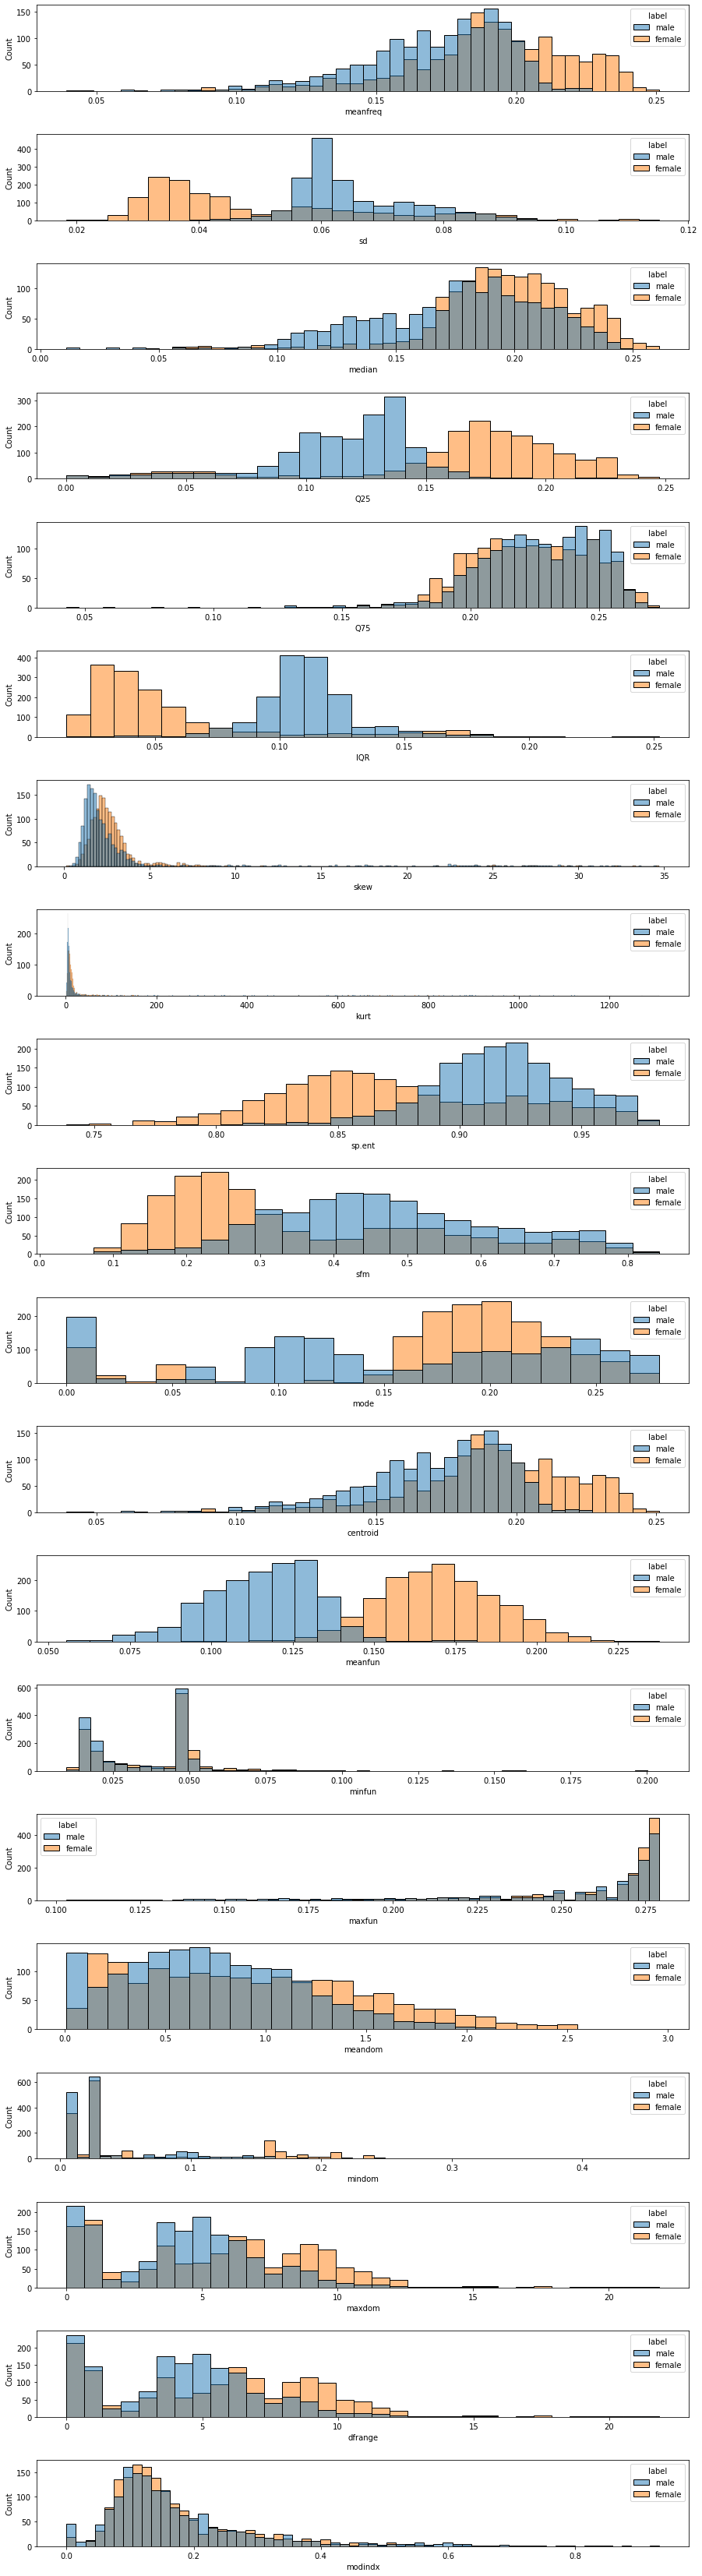

In [212]:
fig=plt.figure(figsize=(15,60))
plt.subplots_adjust(wspace=0, hspace=0.5)
for label_x, column in enumerate(X_columns):
    ax_1 = fig.add_subplot(X_columns.shape[0], 1, label_x+1) 
    sns.histplot(data=df[[column, 'label']], ax=ax_1, hue='label', x=column)

### Отберем все наиболее важные признаки с помощью жадного алгоритма отбора признаков

In [185]:
def add_del(n, 
            features,
            iterations = X_columns.shape[0]):
    Q_error = 0
    Q_error_min = float('inf')
    iter_j = iter_j_ = 0
    print('Входной список фич', features)
    while abs(Q_error_min - Q_error) >= 0.1:
        iter_j = iter_j_ = 0
        while len(features) < n:
            features.append(len(features))
            model = xgb.XGBRFClassifier(objective ='binary:logistic')
            model.fit(X_train[:, features], y_train)
            y_pred = model.predict(X_test[:, features])
            Q_error = log_loss(y_test, y_pred)
            iter_j += 1
            if  Q_error < Q_error_min:
                iter_j_ = iter_j
                Q_error_min = Q_error
            if iter_j - iter_j_ >= iterations:
                break
        
        iter_j = iter_j_ = 0

        while len(features) > 0 and len(features) > iter_j:
            feature = features[iter_j]
            del features[iter_j]
            model = xgb.XGBRFClassifier(objective ='binary:logistic')
            model.fit(X_train[:, features], y_train)
            y_pred = model.predict(X_test[:, features])
            Q_error = log_loss(y_test, y_pred)
            
            if Q_error < Q_error_min:
                iter_j_ = iter_j
                Q_error_min = Q_error
                print('удаляем признак', feature)
            else:
                features.insert(iter_j, feature)
                print('Признак не повлиял, оставляем', feature)
                iter_j += 1
#             print(f'iter_j={iter_j} и iter_j_={iter_j_} len(features)={len(features)}')
            if iter_j - iter_j_ >= iterations:
                break
        print(Q_error_min - Q_error)
    return features








ИТЕРАЦИЯ 0
Входной список фич []
Признак не повлиял, оставляем 0
Признак не повлиял, оставляем 1
Признак не повлиял, оставляем 2
Признак не повлиял, оставляем 3
Признак не повлиял, оставляем 4
Признак не повлиял, оставляем 5
Признак не повлиял, оставляем 6
Признак не повлиял, оставляем 7
Признак не повлиял, оставляем 8
удаляем признак 9
Признак не повлиял, оставляем 10
Признак не повлиял, оставляем 11
Признак не повлиял, оставляем 12
Признак не повлиял, оставляем 13
Признак не повлиял, оставляем 14
Признак не повлиял, оставляем 15
Признак не повлиял, оставляем 16
Признак не повлиял, оставляем 17
Признак не повлиял, оставляем 18
Признак не повлиял, оставляем 19
-0.06541434923278533
ИТЕРАЦИЯ 1
Входной список фич [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
удаляем признак 0
удаляем признак 1
Признак не повлиял, оставляем 2
Признак не повлиял, оставляем 3
Признак не повлиял, оставляем 4
удаляем признак 5
Признак не повлиял, оставляем 6
Признак не повлиял, оставляем 

In [215]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
i = 0
n = X_columns.shape[0]
features_list = []
scaler = preprocessing.MinMaxScaler()
for train_index, test_index in skf.split(X, y):
    print('ИТЕРАЦИЯ', i)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    i += 1
    features = add_del(n, features_list)
    n = len(features)

ИТЕРАЦИЯ 0
Входной список фич []
Признак не повлиял, оставляем 0
Признак не повлиял, оставляем 1
Признак не повлиял, оставляем 2
Признак не повлиял, оставляем 3
Признак не повлиял, оставляем 4
Признак не повлиял, оставляем 5
Признак не повлиял, оставляем 6
Признак не повлиял, оставляем 7
Признак не повлиял, оставляем 8
удаляем признак 9
Признак не повлиял, оставляем 10
Признак не повлиял, оставляем 11
Признак не повлиял, оставляем 12
Признак не повлиял, оставляем 13
Признак не повлиял, оставляем 14
Признак не повлиял, оставляем 15
Признак не повлиял, оставляем 16
Признак не повлиял, оставляем 17
Признак не повлиял, оставляем 18
Признак не повлиял, оставляем 19
-0.06541434923278533
ИТЕРАЦИЯ 1
Входной список фич [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
удаляем признак 0
удаляем признак 1
Признак не повлиял, оставляем 2
Признак не повлиял, оставляем 3
Признак не повлиял, оставляем 4
удаляем признак 5
Признак не повлиял, оставляем 6
Признак не повлиял, оставляем 

In [216]:
print('Какие колонки остались',df.columns[features].tolist())
print()
print('Какие колонки были до feature selection',df.columns.tolist())

Какие колонки остались ['Q25', 'skew', 'kurt', 'sp.ent', 'mode', 'centroid', 'meanfun', 'mindom', 'dfrange', 'modindx']

Какие колонки были до feature selection ['meanfreq', 'sd', 'median', 'Q25', 'Q75', 'IQR', 'skew', 'kurt', 'sp.ent', 'sfm', 'mode', 'centroid', 'meanfun', 'minfun', 'maxfun', 'meandom', 'mindom', 'maxdom', 'dfrange', 'modindx', 'label']


In [234]:
features

[3, 6, 7, 8, 10, 11, 12, 16, 18, 19]

### Проводим поиск подходящих гиперпараметров для модели

In [261]:
parameters = {
    'xgbrfclassifier__max_depth': range(2, 10, 1),
    'xgbrfclassifier__n_estimators': range(60, 220, 40),
    'xgbrfclassifier__learning_rate': [0.1, 0.01, 0.05],
    'xgbrfclassifier__subsample': [0.5, 1]
}


clf = make_pipeline(preprocessing.MinMaxScaler(), xgb.XGBRFClassifier(objective ='binary:logistic'))

grid_search = GridSearchCV(clf,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = -1,
    cv = 3,
    verbose=True)

grid_search.fit(df[df.columns[features]], y)

Fitting 3 folds for each of 192 candidates, totalling 576 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('xgbrfclassifier',
                                        XGBRFClassifier(base_score=None,
                                                        booster=None,
                                                        callbacks=None,
                                                        colsample_bylevel=None,
                                                        colsample_bytree=None,
                                                        early_stopping_rounds=None,
                                                        enable_categorical=False,
                                                        eval_metric=None,
                                                        gamma=None, gpu_id=None,
                                                        grow_policy=None,
                                                        importance_type=None,
  

In [263]:
grid_search.best_estimator_

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbrfclassifier',
                 XGBRFClassifier(base_score=0.5, booster='gbtree',
                                 callbacks=None, colsample_bylevel=1,
                                 colsample_bytree=1, early_stopping_rounds=None,
                                 enable_categorical=False, eval_metric=None,
                                 gamma=0, gpu_id=-1, grow_policy='depthwise',
                                 importance_type=None,
                                 interaction_constraints='', learning_rate=0.05,
                                 max_bin=256, max_cat_to_onehot=4,
                                 max_delta_step=0, max_depth=9, max_leaves=0,
                                 min_child_weight=1, missing=nan,
                                 monotone_constraints='()', n_estimators=180,
                                 n_jobs=0, num_parallel_tree=180,
                                 objective='binary

In [264]:
grid_search.best_score_

0.986897861187634

### Проверяем готовую модель на кросс-валидации

In [271]:
X_columns = df.columns[:-1]
X = df[df.columns[:-1]].to_numpy()
print('Признаки', X.shape)
# display(X.head())
print()
y_columns = df.columns[-1]
le = preprocessing.LabelEncoder()
le.fit(df[df.columns[-1]].unique())
y = le.transform(df[df.columns[-1]].to_numpy())
print('Метки', y.shape)
# display(y.head())

Признаки (3168, 20)

Метки (3168,)


In [277]:

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
i = 0
n = X_columns.shape[0]
features_list = []
scaler = preprocessing.MinMaxScaler()
result = np.array([])
for train_index, test_index in skf.split(X, y):
    print('ИТЕРАЦИЯ', i)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    grid_search.best_estimator_['xgbrfclassifier'].fit(X_train, y_train)
    y_pred = grid_search.best_estimator_['xgbrfclassifier'].predict(X_test)
    result = np.append(result, roc_auc_score(y_test, y_pred))
    i += 1
result.mean()

ИТЕРАЦИЯ 0
ИТЕРАЦИЯ 1
ИТЕРАЦИЯ 2


0.9734848484848485

### Вывод

Обучение прошло успешно, в 2.7 процента классификатор ошибается. Возможно, можно оптимизировать алгоритм, но в принципе, модель угадывает практически в ста процентах случаев.